In [1]:
import matplotlib.pyplot as plt
import json
import os
import cv2
import time
import numpy as np
from csbdeep.utils import Path, normalize
from segmentation import MELC_Segmentation
import pickle
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import umap
import scanpy as sc
import anndata as ad


2023-06-14 10:24:58.446712: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-14 10:24:58.447898: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 10:24:58.473122: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 10:24:58.473463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 10:24:58.845665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
segment = "nuclei"
dfs = list()
fields_of_view = [f for f in os.listdir(f"./marker_expression_{segment}_results/") if f.endswith(".pkl")]

for fov in fields_of_view:
    df = pd.read_pickle(f"./marker_expression_nuclei_results/{fov}")  
    df["Field of View"] = fov.split(".")[0]
    df["Sample"] = fov.split(" ")[0]
    df["Group"] = "Case" if "ALS" in fov else "Control"
    temp = df.index
    df["Index"] = df.index
    df = df.set_index(["Field of View", "Index"])
    dfs.append(df)

expression_data = pd.concat(dfs)
expression_data = expression_data.sort_index()

y_cols = ["Group", "Sample"]
ys = expression_data[y_cols]
Xs = expression_data.drop(labels=y_cols, axis=1)

Xs_normalized = StandardScaler().fit_transform(Xs)

#df_normalized = pd.DataFrame(data=Xs, index=Xs.index, columns=Xs.columns)

#binary_df = (df_normalized > 0)
#binary_df = binary_df.astype(int)
#binary_df.to_pickle(f"./binary_expression_{segment}_1.pkl")  

In [96]:
expression_data.iloc[:,:-3] = Xs_normalized

In [5]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.9.1 pandas==2.0.1 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


In [6]:
sample_names = expression_data.index.get_level_values('Field of View')
cell_counts = expression_data.index.get_level_values('Index')

# Convert the DataFrame to AnnData
adata = ad.AnnData(expression_data.drop(columns=['Sample', 'Group']).values)

# Set the sample names and cell counts as observations and variables in the AnnData object
adata.obs['sample_name'] = sample_names
adata.obs['cell_count'] = cell_counts
adata.obs['sample'] = expression_data["Sample"].values
adata.obs['group'] = expression_data["Group"].values


# Optionally, you may want to transpose the data if the antigens are in columns and cells are in rows
#adata = adata.transpose()

# Perform any necessary preprocessing steps
# For example, you can normalize the data using scanpy's pp.normalize_total function
sc.pp.normalize_total(adata)

sc.pp.neighbors(adata)


# Run PCA on the data
#sc.pp.pca(adata)

# Perform Leiden clustering
sc.tl.leiden(adata)

# Access the cluster labels
cluster_labels = adata.obs['leiden']
sc.tl.umap(adata)
# You can also access the cluster assignments as an array using
# cluster_labels = adata.obs.leiden.values

# Print the cluster labels
print(cluster_labels)

normalizing counts per cell
    finished (0:00:00)
computing neighbors
    using data matrix X directly


_normalization.py (197): Some cells have zero counts


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)
running Leiden clustering
    finished: found 38 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:12)
0         12
1         14
2          6
3          0
4         21
          ..
171149     8
171150    12
171151     7
171152    22
171153    12
Name: leiden, Length: 171154, dtype: category
Categories (38, object): ['0', '1', '2', '3', ..., '34', '35', '36', '37']


In [7]:
adata.obs['sample'] = expression_data["Sample"].values
adata.obs['group'] = expression_data["Group"].values

scatterplots.py (392): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


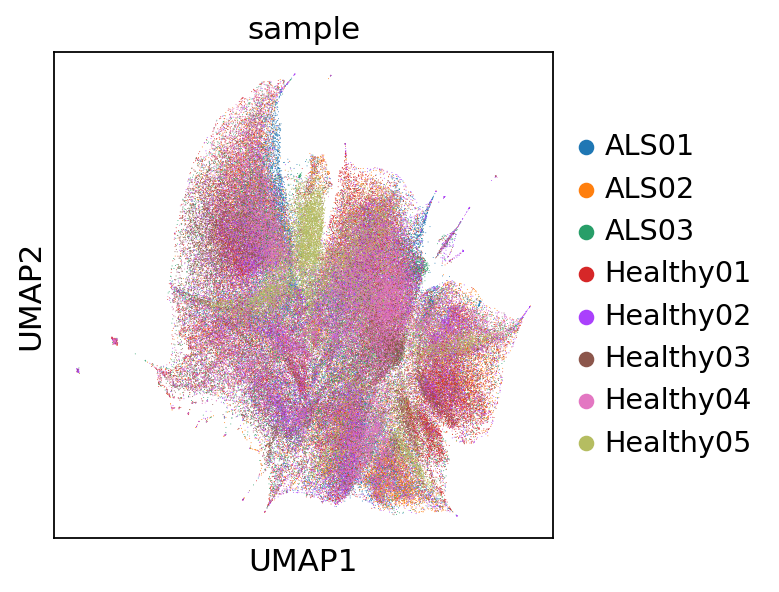

In [8]:
sc.pl.umap(adata, color='sample')

scatterplots.py (392): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


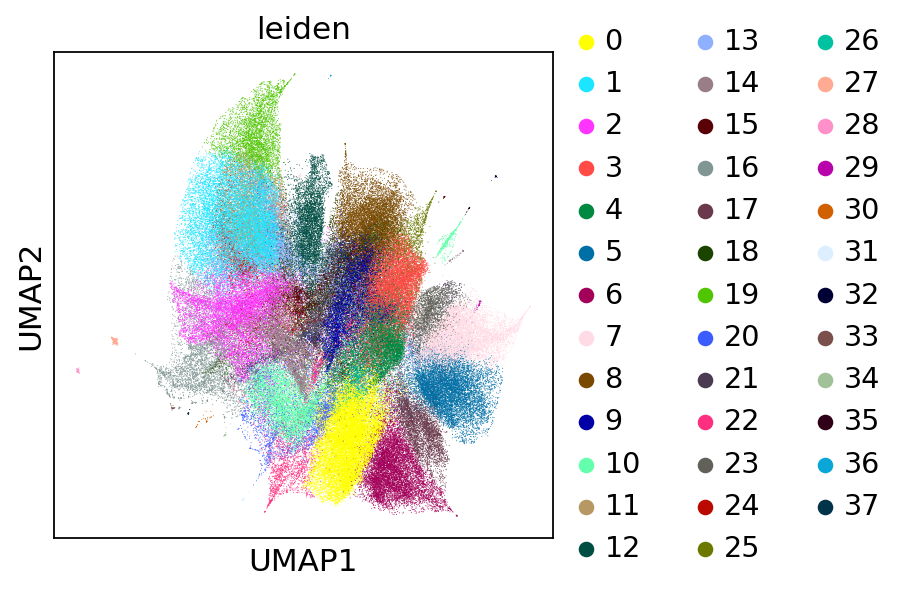

In [9]:
sc.pl.umap(adata, color='leiden')

In [34]:
leiden = adata.obs["leiden"].values.to_numpy().astype(int)
sample = adata.obs["sample"].values.to_numpy().astype(str)
df = pd.DataFrame({"leiden": leiden, "sample": sample})

leiden_labels = np.unique(leiden)
samples = np.unique(sample)

conf = np.zeros((len(leiden_labels), len(samples)))
for i, l in enumerate(leiden_labels):
    for j, s in enumerate(samples):             
        conf[i,j] = len(np.where(sample[np.where(leiden == l)] == s)[0])

In [45]:
conf_df = pd.DataFrame(conf, index=leiden_labels, columns=samples).T
conf_df["sum"] = conf_df.sum(axis=1)

In [53]:
rel_conf = conf_df.iloc[:,:-1].div(conf_df["sum"], axis=0)

<Axes: >

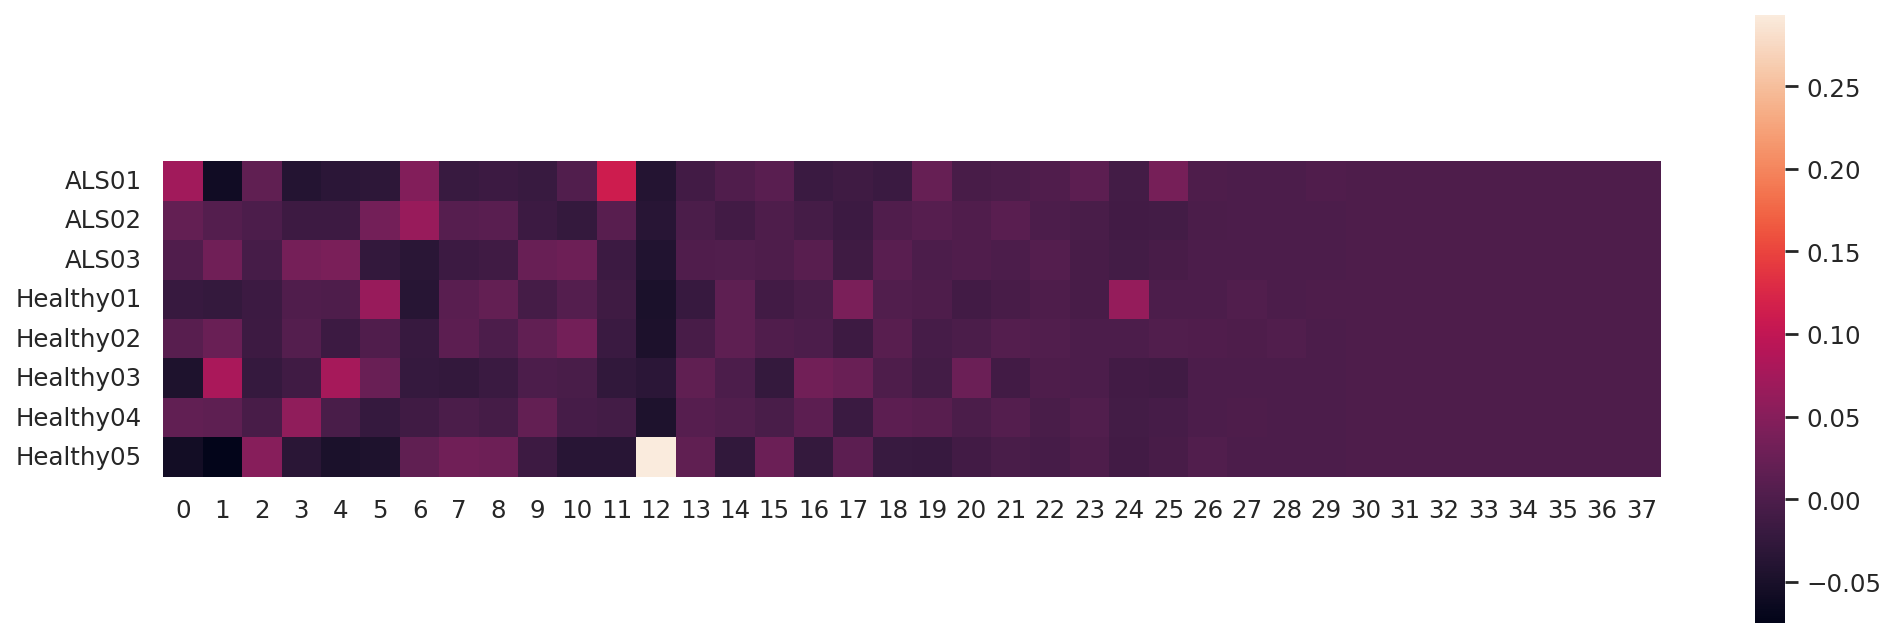

In [156]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.heatmap(rel_conf,square=True)

In [83]:
expression_data["leiden"] = leiden

Index(['CD11b-PE', 'CD16-PE', 'CD2-FITC', 'CD26-PE', 'CD29-FITC', 'CD3-PE',
       'CD36-FITC', 'CD38-PE', 'CD4-PE', 'CD45-PE', 'CD45RA-PE', 'CD56-PE',
       'CD57-PE', 'CD7-PE', 'CD8-PE', 'HLA-DQ-FITC', 'HLA-DR-PE', 'NeuN-AF488',
       'PBS', 'Sample', 'Group'],
      dtype='object')

In [129]:
binary_cluster_centers = np.zeros((len(leiden_labels), 19))
for i in range(len(leiden_labels)):
    (expression_data[expression_data["leiden"] == i].drop(["Sample", "Group"], axis=1).mean(axis=0) > 0).astype(int)
    binary_cluster_centers[i] = (expression_data[expression_data["leiden"] == i].drop(["Sample", "Group"], axis=1).mean(axis=0) > 0).astype(int)[:-1]

In [136]:
binary_cluster_center_df = pd.DataFrame(binary_cluster_centers.T, index = expression_data.columns[:-3])

In [144]:
binary_cluster_center_df["Patent profile"] = [0, 1] + [np.nan] * 13 + [0] + [np.nan] * 3
binary_cluster_center_df["Publication profile"] = [0, 1] + [np.nan] * 8 + [1] + [np.nan] * 8

<Axes: >

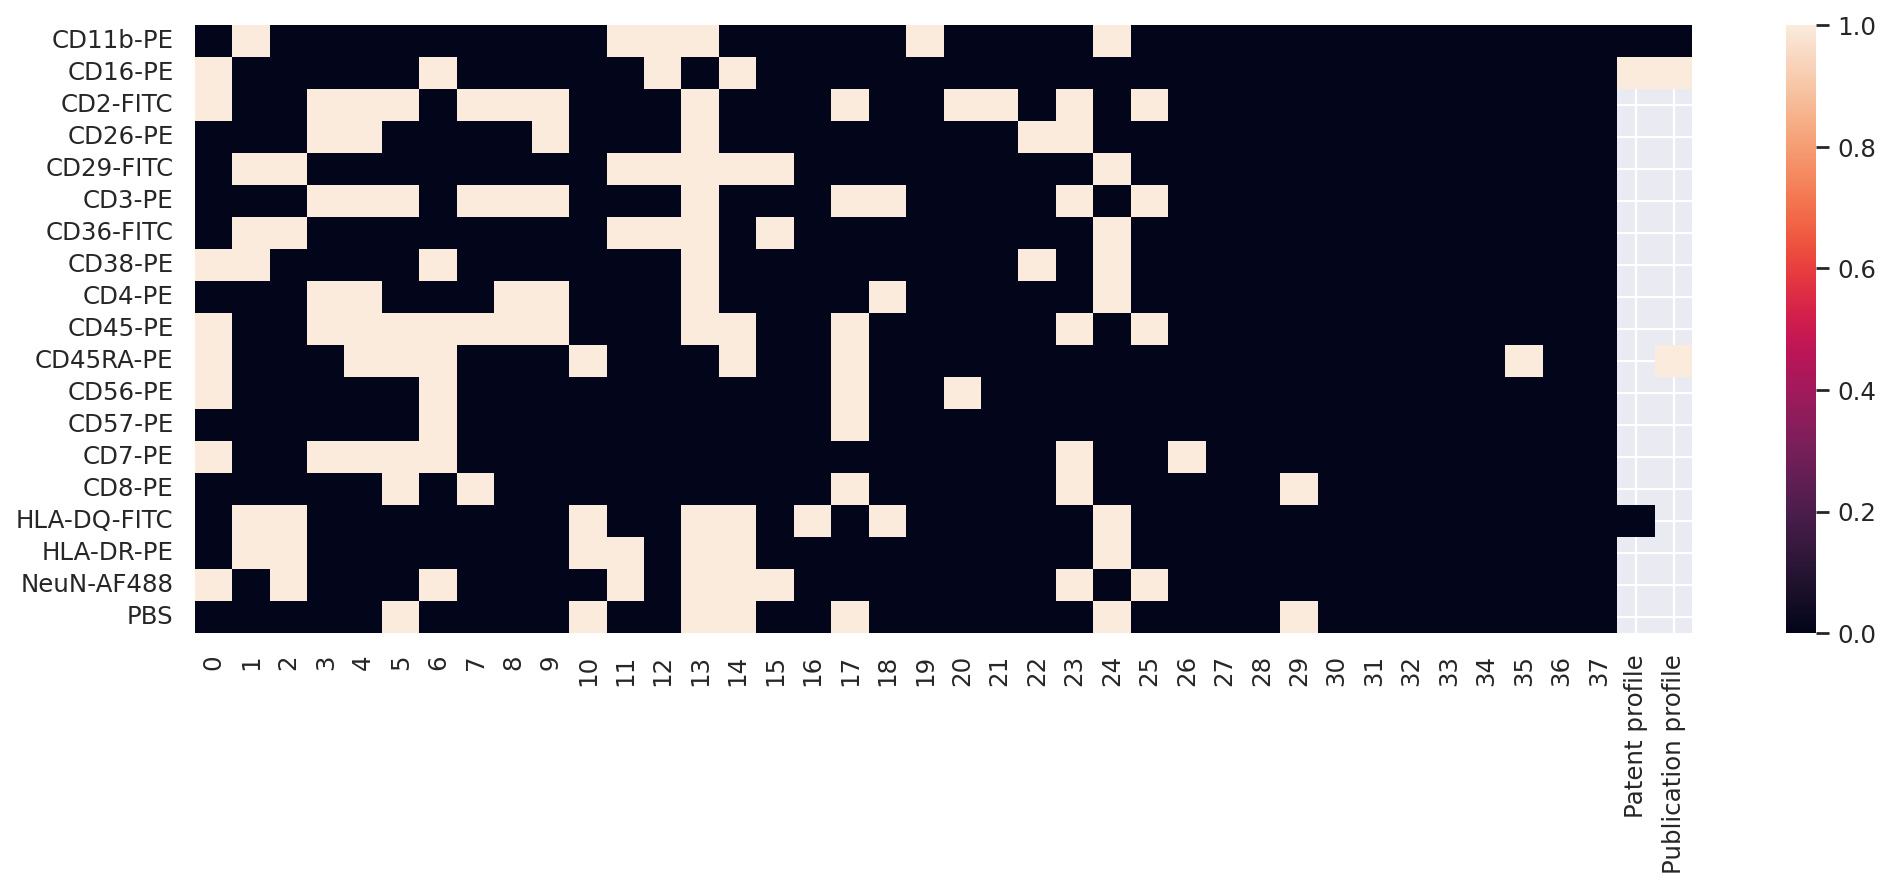

In [147]:
sns.set_theme()
sns.heatmap(binary_cluster_center_df)

In [120]:
binary_cluster_center[1]

CD11b-PE       1
CD16-PE        0
CD2-FITC       0
CD26-PE        0
CD29-FITC      1
CD3-PE         0
CD36-FITC      1
CD38-PE        1
CD4-PE         0
CD45-PE        0
CD45RA-PE      0
CD56-PE        0
CD57-PE        0
CD7-PE         0
CD8-PE         0
HLA-DQ-FITC    1
HLA-DR-PE      1
NeuN-AF488     0
PBS            0
leiden         1
dtype: int64

In [115]:
cluster_center_1 = (expression_data[expression_data["leiden"] == 1].drop(["Sample", "Group"], axis=1).mean(axis=0) > 0).astype(int) 
cluster_center_1

CD11b-PE       1
CD16-PE        0
CD2-FITC       0
CD26-PE        0
CD29-FITC      1
CD3-PE         0
CD36-FITC      1
CD38-PE        1
CD4-PE         0
CD45-PE        0
CD45RA-PE      0
CD56-PE        0
CD57-PE        0
CD7-PE         0
CD8-PE         0
HLA-DQ-FITC    1
HLA-DR-PE      1
NeuN-AF488     0
PBS            0
leiden         1
dtype: int64

In [104]:
cluster_center_12 = (expression_data[expression_data["leiden"] == 12].drop(["Sample", "Group"], axis=1).mean(axis=0) > 0).astype(int)

In [105]:
cluster_center_11 = (expression_data[expression_data["leiden"] == 11].drop(["Sample", "Group"], axis=1).mean(axis=0) > 0).astype(int)

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(leiden, sample)

ValueError: Mix of label input types (string and number)

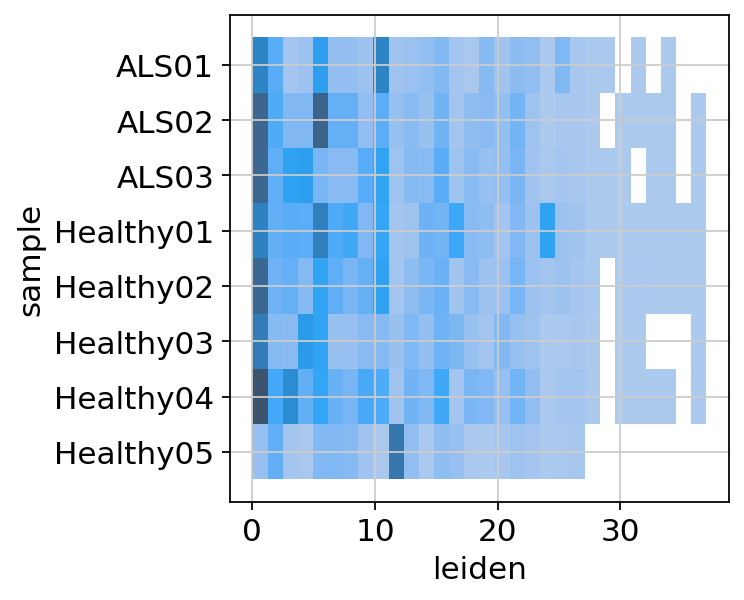

In [14]:
sns.histplot(data=df, x="leiden", y="sample", kde=True, bins=(30, 30))
plt.show()

In [ ]:
sample

In [ ]:
adata["leiden"]

In [ ]:
df = pd.DataFrame({'Sample': expression_data["Sample"].values, 'Leiden Cluster': cluster_labels.values})
cluster_counts = df.groupby(['Sample', 'Leiden Cluster']).size().unstack(fill_value=0)

# Set up the figure and axes for the bar plot
fig, ax = plt.subplots(figsize=(8, 6))

# Use Seaborn's barplot function to create the stacked bar plot
sns.barplot(data=cluster_counts, ax=ax, hue="Sample")

# Customize the plot
ax.set_xlabel('Sample')
ax.set_ylabel('Number of Cells')
ax.set_title('Cell Clusters by Sample Name')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
df

In [ ]:
adata

In [ ]:
adata

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(Xs_normalized)
res_df = ys.copy()
res_df["UMAP Dim1"] = embedding[:,0]
res_df["UMAP Dim2"] = embedding[:,1]
sns.scatterplot(res_df, x="UMAP Dim1", y="UMAP Dim2", hue="Sample", alpha=0.7, s=1)
plt.show()

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(Xs_normalized)
res_df = ys.copy()
res_df["UMAP Dim1"] = embedding[:,0]
res_df["UMAP Dim2"] = embedding[:,1]
sns.scatterplot(res_df, x="UMAP Dim1", y="UMAP Dim2", hue="Group", alpha=0.2, s=1)
plt.show()

In [ ]:
g = sns.relplot(
    data=res_df,
    x="UMAP Dim1", y="UMAP Dim2", hue="Sample", col="Sample",
    kind="scatter", linewidth=4, zorder=5, s=1,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Reduce the frequency of the x axis ticks
g.tight_layout()
plt.show()

In [ ]:
pca = PCA(2)
res = pca.fit_transform(Xs_normalized)
res_df = ys.copy()
res_df["PCA Dim1"] = res[:,0]
res_df["PCA Dim2"] = res[:,1]
sns.scatterplot(res_df, x="PCA Dim1", y="PCA Dim2", hue="Sample", alpha=0.5, s=1)
plt.show()

In [ ]:
g = sns.relplot(
    data=res_df,
    x="PCA Dim1", y="PCA Dim2", hue="Sample", col="Sample",
    kind="scatter", linewidth=4, zorder=5, s=1,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Reduce the frequency of the x axis ticks
g.tight_layout()
plt.show()

In [ ]:
def conf_heatmap(res_df, props1, props2):
    hm = np.zeros((len(np.unique(res_df[props1])), len(np.unique(res_df[props2]))))

    for i, p1 in enumerate(np.unique(res_df[props1])):
        for j, p2 in enumerate(np.unique(res_df[props2])):
            sub_df = res_df[res_df[props1]==p1]
            sub_df = sub_df[sub_df[props2]==p2]
            hm[i,j] = len(sub_df)

    sns.heatmap(hm, annot=True, xticklabels=np.unique(res_df[props2]), yticklabels=np.unique(res_df[props1]), vmin=0, vmax=len(res_df))
    plt.tight_layout()
    plt.show()

In [ ]:
conf_heatmap(res_df, props1="2-Means Label", props2="Group")

In [ ]:
conf_heatmap(res_df, props1="8-Means Label", props2="Group")

In [ ]:
conf_heatmap(res_df, props1="2-Means Label", props2="Sample")

In [ ]:
conf_heatmap(res_df, props1="8-Means Label", props2="Sample")